# Process NO2 data from Cloud Raster Format file

In [138]:
from arcgis.gis import GIS
from arcgis.raster import RasterCollection, Raster
from arcgis.raster import functions
import arcpy
import matplotlib.pyplot as plt
import numpy as np

In [2]:
crf_path = r'\\Mac\Home\Documents\GIS_data\Imagery\sentinel-5p\ny-2019-2020\ny_crf\ny_19_20.crf'

In [3]:
gis= GIS()

## Read into an arcpy `RasterCollection`

In [4]:
all_rc = arcpy.ia.RasterCollection(crf_path)

In [5]:
all_rc

,Variable,StdTime,Raster
0,/product/nitrogendioxide_tropospheric_column,2019-04-01T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x477ae826...
1,/product/nitrogendioxide_tropospheric_column,2019-04-03T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\xf2479549...
2,/product/nitrogendioxide_tropospheric_column,2019-04-04T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x4477f08d...
3,/product/nitrogendioxide_tropospheric_column,2019-04-05T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x966b7bac...
4,/product/nitrogendioxide_tropospheric_column,2019-04-06T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x8a8af544...
5,/product/nitrogendioxide_tropospheric_column,2019-04-07T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x4dcb019f...
6,/product/nitrogendioxide_tropospheric_column,2020-04-01T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x71c5f2f1...
7,/product/nitrogendioxide_tropospheric_column,2020-04-02T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\xc1d8d24d...
8,/product/nitrogendioxide_tropospheric_column,2020-04-03T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\x967d0bb6...
9,/product/nitrogendioxide_tropospheric_column,2020-04-04T00:00:00+00:00,C:\Users\atma6951\AppData\Local\Temp\xf0a67c37...


### Filter out data for 2019 and 2020

In [9]:
type(all_rc)

arcpy.ia.RasterCollection.RasterCollection

In [11]:
all_2019 = all_rc.filterByCalendarRange('YEAR',2019,2019)
all_2020 = all_rc.filterByCalendarRange('YEAR',2020,2020)
print(all_2019.count, all_2020.count)

12 12


In [146]:
no2_19 = all_2019.filterByAttribute(field_name='Variable', 
                                          operator='CONTAINS', 
                                          field_values='nitrogendioxide')

no2_20 = all_2020.filterByAttribute(field_name='Variable', 
                                          operator='CONTAINS', 
                                          field_values='nitrogendioxide')
print(no2_19.count, no2_20.count)

6 6


In [147]:
qa_19 = all_2019.filterByAttribute(field_name='Variable', 
                                          operator='CONTAINS', 
                                          field_values='qa_value')

qa_20 = all_2020.filterByAttribute(field_name='Variable', 
                                          operator='CONTAINS', 
                                          field_values='qa_value')
print(qa_19.count, qa_20.count)

6 6


## Read individual `Raster`s from `RasterCollection`

In [14]:
no2_19

,Raster,Variable,StdTime
0,C:\Users\atma6951\AppData\Local\Temp\x3a228ee2...,/product/nitrogendioxide_tropospheric_column,2019-04-01T00:00:00+00:00
1,C:\Users\atma6951\AppData\Local\Temp\x7b4ea38e...,/product/nitrogendioxide_tropospheric_column,2019-04-03T00:00:00+00:00
2,C:\Users\atma6951\AppData\Local\Temp\x47a156eb...,/product/nitrogendioxide_tropospheric_column,2019-04-04T00:00:00+00:00
3,C:\Users\atma6951\AppData\Local\Temp\xcb8914ec...,/product/nitrogendioxide_tropospheric_column,2019-04-05T00:00:00+00:00
4,C:\Users\atma6951\AppData\Local\Temp\x75d59f01...,/product/nitrogendioxide_tropospheric_column,2019-04-06T00:00:00+00:00
5,C:\Users\atma6951\AppData\Local\Temp\x2b7923fd...,/product/nitrogendioxide_tropospheric_column,2019-04-07T00:00:00+00:00


In [15]:
r1 = no2_19[0]['Raster']
type(r1)

arcpy.sa.Raster.Raster

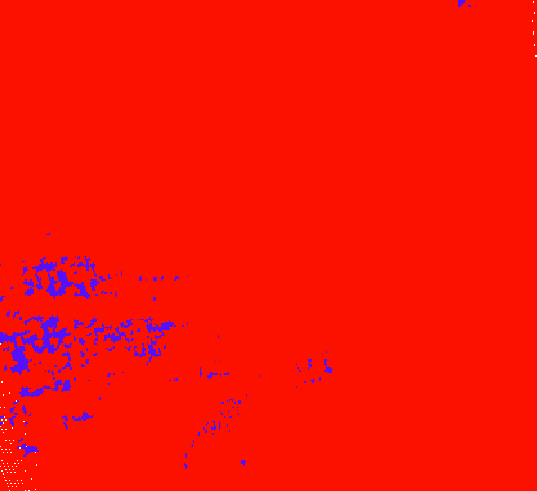

In [20]:
qa1 = qa_19[0]['Raster']
qa1

### Filter out bad cells

In [106]:
arcpy.env.matchMultidimensionalVariable = False

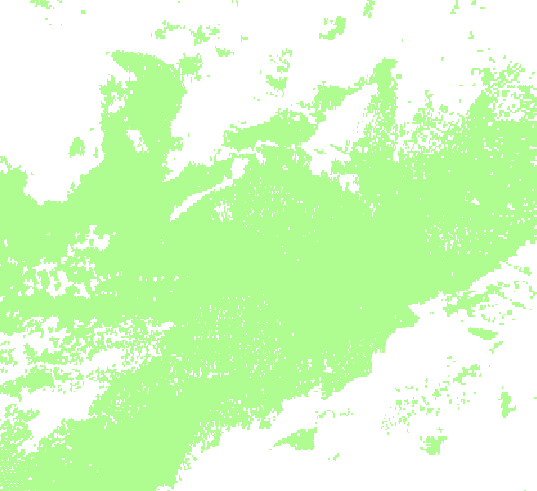

In [119]:
r1_filtered = arcpy.ia.Con((qa1>=0.75)&(r1>=0), r1)
r1_filtered

In [120]:
r1_filtered.minimum, r1_filtered.maximum

(9.787409077643972e-11, 0.00023641456209588796)

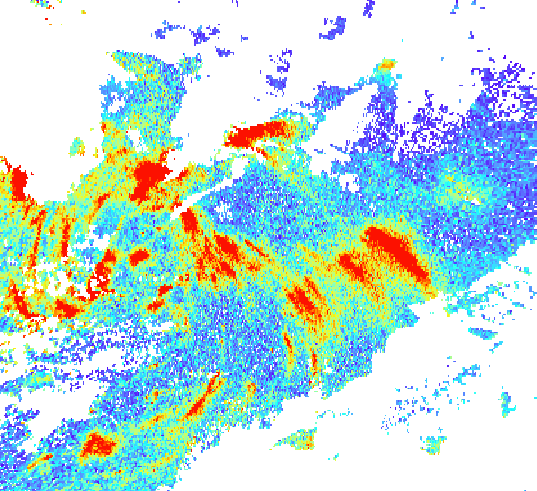

In [121]:
arcpy.ia.Stretch(r1_filtered, 'StdDev', num_stddev=2)

## Map out on all rasters in RC

In [122]:
no2_19[2]

{'Raster': C:\Users\atma6951\AppData\Local\Temp\x47a156eb_60c5_4fbc_b7e6_589071847332y0.afr,
 'Variable': '/product/nitrogendioxide_tropospheric_column',
 'StdTime': '2019-04-04T00:00:00+00:00'}

In [123]:
qa_19[2]['StdTime'].split('+')

['2019-04-04T00:00:00', '00:00']

In [124]:
qa_19.count

6

In [126]:
qa_19.filterByTime(no2_19[2]['StdTime'].split('+')[0], no2_19[2]['StdTime'].split('+')[0])

,Raster,Variable,StdTime
0,C:\Users\atma6951\AppData\Local\Temp\x63ecc0a7...,/product/qa_value,2019-04-04T00:00:00+00:00


In [129]:
def find_valid_cells(item, qa_rc=qa_19):
    no2_ras = item['Raster']
    qa2_rc = qa_rc.filterByTime(item['StdTime'].split('+')[0], item['StdTime'].split('+')[0])
    qa2_ras = qa2_rc[0]['Raster']
    
    # filter out and retain only good cells
    no2_filtered = arcpy.ia.Con((qa2_ras>=0.75)&(no2_ras>=0), no2_ras)
    
    return {'raster': no2_filtered, 'StdTime': item['StdTime']}

In [145]:
%%time
no2_processed_rc = no2_19.map(find_valid_cells)

TypeError: map() takes 2 positional arguments but 3 were given

In [131]:
no2_processed_rc

,Raster,StdTime
0,C:\Users\atma6951\AppData\Local\Temp\x830328d8...,2019-04-01T00:00:00+00:00
1,C:\Users\atma6951\AppData\Local\Temp\x0afd96ed...,2019-04-03T00:00:00+00:00
2,C:\Users\atma6951\AppData\Local\Temp\xfdb8478e...,2019-04-04T00:00:00+00:00
3,C:\Users\atma6951\AppData\Local\Temp\xb37080cd...,2019-04-05T00:00:00+00:00
4,C:\Users\atma6951\AppData\Local\Temp\x287c9fea...,2019-04-06T00:00:00+00:00
5,C:\Users\atma6951\AppData\Local\Temp\x53cd8687...,2019-04-07T00:00:00+00:00


### Reduce

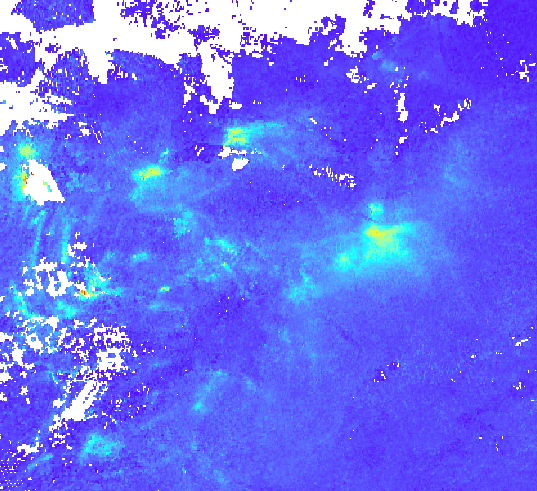

In [132]:
no2_2019_mean = no2_processed_rc.mean()
no2_2019_mean

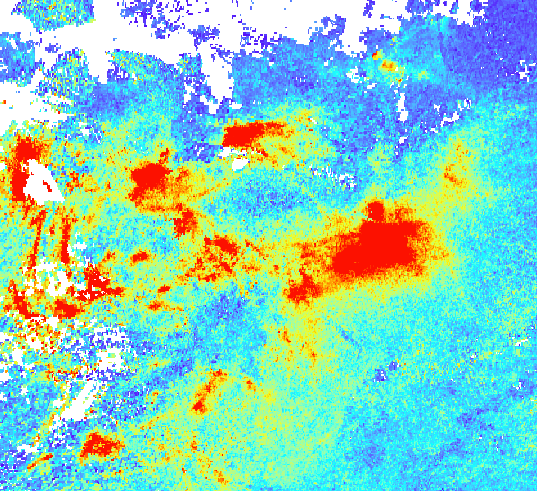

In [133]:
arcpy.ia.Stretch(no2_2019_mean, 'StdDev', num_stddev=2)

### View on a map

In [142]:
map1 = gis.map('New York')
map1

MapView(layout=Layout(height='400px', width='100%'))

In [144]:
# map1.add_layer(no2_2019_mean)
map1.add_layer(functions.stretch(ags_ras, 'StdDev', num_stddev=2))

<class 'arcgis.raster._layer.Raster'>


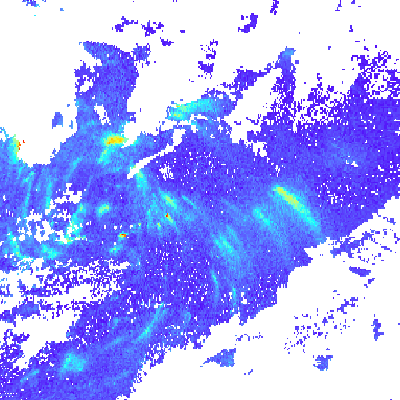

In [143]:
ags_ras = Raster(no2_2019_mean)
print(type(ags_ras))
functions.stretch(ags_ras, 'StdDev', num_stddev=2)

# Run on 2020 data

In [150]:
def find_valid_cells(item, qa_rc=qa_20):
    no2_ras = item['Raster']
    qa2_rc = qa_rc.filterByTime(item['StdTime'].split('+')[0], item['StdTime'].split('+')[0])
    qa2_ras = qa2_rc[0]['Raster']
    
    # filter out and retain only good cells
    no2_filtered = arcpy.ia.Con((qa2_ras>=0.75)&(no2_ras>=0), no2_ras)
    
    return {'raster': no2_filtered, 'StdTime': item['StdTime']}

In [152]:
%%time
no2_20_processed = no2_20.map(find_valid_cells)
no2_20_processed

Wall time: 153 ms


,Raster,StdTime
0,C:\Users\atma6951\AppData\Local\Temp\x4945011c...,2020-04-01T00:00:00+00:00
1,C:\Users\atma6951\AppData\Local\Temp\x859a8ffa...,2020-04-02T00:00:00+00:00
2,C:\Users\atma6951\AppData\Local\Temp\xe428c0e1...,2020-04-03T00:00:00+00:00
3,C:\Users\atma6951\AppData\Local\Temp\xb379c94f...,2020-04-04T00:00:00+00:00
4,C:\Users\atma6951\AppData\Local\Temp\x7a0f1d4c...,2020-04-05T00:00:00+00:00
5,C:\Users\atma6951\AppData\Local\Temp\xf6b4deb4...,2020-04-06T00:00:00+00:00


### Reduce

Wall time: 6.12 ms


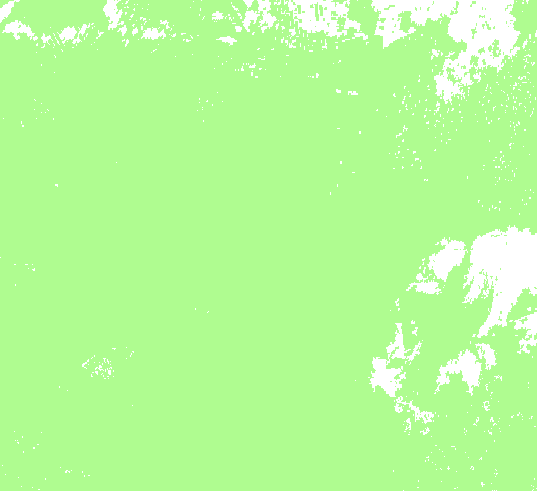

In [155]:
%%time
no2_20_mean = no2_20_processed.mean()
arcpy.ia.Stretch(no2_20_mean, 'StdDev', num_stddev=1)

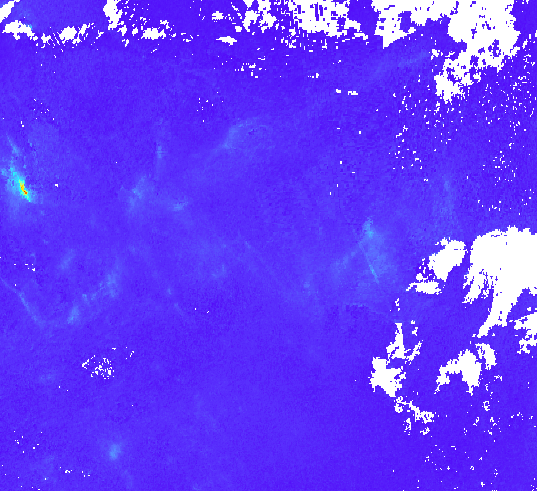

In [154]:
no2_20_mean

In [156]:
no2_20_mean.minimum, no2_20_mean.maximum

(6.12570327795936e-10, 0.0006397434626705945)

### Save to disk

In [159]:
no2_2019_mean.save(r'Y:\Documents\GIS_data\Imagery\sentinel-5p\ny-2019-2020\outputs\arcpy_workflow\no2_2019.crf')

In [160]:
no2_20_mean.save(r'Y:\Documents\GIS_data\Imagery\sentinel-5p\ny-2019-2020\outputs\arcpy_workflow\no2_2020.crf')

In [164]:
no2_2019_mean.mean, no2_20_mean.mean

(2.3067695501696567e-05, 1.889373185900351e-05)